In [83]:
from abc import ABC, abstractmethod
import glob
import re
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import utils
from torch import optim

from senseis.torch_module.loss import WeightedBCELoss

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, recall_score

import matplotlib.pyplot as plt

In [2]:
# weighted BCE training on return, weight on actual return magnitude

In [3]:
%matplotlib inline

In [4]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_built()
if use_cuda:
    device = torch.device('cuda')
elif use_mps:
    device = torch.device('mps')
else:
    device = torch.device('cpu')
cpu = torch.device('cpu')

In [5]:
default_batch_size = 256
loader_args = {'batch_size' : default_batch_size, 'shuffle' : True, 'num_workers' : 0}
score_args = {'batch_size' : default_batch_size, 'shuffle': False, 'num_workers' : 0}
if use_cuda:
    loader_args.update({'pin_memory' : True})
    score_args.update({'pin_memory' : True})

In [6]:
class SLReporter(ABC):
    @abstractmethod
    def train_gather(self, epoch, batch_idx, batch_size, dataset_size, loss):
        pass
    @abstractmethod
    def eval_gather(self, train_epoch, loss, accuracies):
        pass
    @abstractmethod
    def eval_pred_gather(self, train_epoch, predictions, targets):
        pass
    @abstractmethod
    def train_reset(self):
        pass
    @abstractmethod
    def eval_reset(self):
        pass

class SLEpochLossReporter(SLReporter):
    def __init__(self, batch_size, frequency, report_frequency = 0, eval_report_frequency = 0):
        self.batch_size = batch_size
        self.frequency = frequency
        self.report_frequency = report_frequency
        self.eval_report_frequency = eval_report_frequency
        self.losses = []
        self.eval_losses = []
        self.eval_predictions_targets = []
    def train_gather(self, epoch, batch_idx, dataset_size, loss):
        if epoch % self.frequency == 0 and (batch_idx + 1) * self.batch_size >= dataset_size:
            self.losses.append((epoch, loss))
        if self.report_frequency > 0 and epoch % self.report_frequency == 0 and (batch_idx + 1) * self.batch_size >= dataset_size:
            print("Epoch {}, {}/{}: {}".format(epoch, batch_idx * self.batch_size, dataset_size, loss))
    def eval_gather(self, train_epoch, loss, accuracies):
        self.eval_losses.append([train_epoch, loss] + accuracies)
        if self.eval_report_frequency > 0 and train_epoch % self.eval_report_frequency == 0:
            print("Epoch {}: loss {} accuracy {}".format(train_epoch, loss, accuracies))
    def eval_pred_gather(self, train_epoch, predictions, targets):
        self.eval_predictions_targets.append((train_epoch, predictions, targets))
    def train_reset(self):
        self.losses = []
    def eval_reset(self):
        self.eval_losses = []
        self.eval_predictions_targets = []

class SLBatchLossReporter(SLReporter):
    def __init__(self, batch_size, frequency, report_frequency = 0, eval_report_frequency = 0):
        self.batch_size = batch_size
        self.frequency = frequency
        self.report_frequency = report_frequency
        self.eval_report_frequency = eval_report_frequency
        self.losses = []
        self.eval_losses = []
        self.eval_predictions_targets = []
    def train_gather(self, epoch, batch_idx, dataset_size, loss):
        if epoch % self.frequency == 0 and (batch_idx + 1) * self.batch_size >= dataset_size:
            self.losses.append((epoch, loss))
        if self.report_frequency > 0 and epoch % self.report_frequency == 0:
            print("Epoch {}, {}/{}: {}".format(epoch, batch_idx * self.batch_size, dataset_size, loss))
    def eval_gather(self, train_epoch, loss, accuracies):
        self.eval_losses.append([train_epoch, loss] + accuracies)
        if self.eval_report_frequency > 0 and train_epoch % self.eval_report_frequency == 0:
            print("Epoch {}: loss {} accuracy {}".format(train_epoch, loss, accuracies))
    def eval_pred_gather(self, train_epoch, predictions, targets):
        self.eval_predictions_targets.append((train_epoch, predictions, targets))
    def train_reset(self):
        self.losses = []
    def eval_reset(self):
        self.eval_losses = []
        self.eval_predictions_targets = []

In [7]:
data_dir = '../data/'

In [8]:
files = glob.glob(data_dir + 'etl_s2_v2*.parquet')
files

['../data/etl_s2_v2_1682465280_1682618880.parquet',
 '../data/etl_s2_v2_1681390080_1681543680.parquet',
 '../data/etl_s2_v2_1680419520_1680590400.parquet',
 '../data/etl_s2_v2_1680112320_1680265920.parquet',
 '../data/etl_s2_v2_1680897600_1681051200.parquet',
 '../data/etl_s2_v2_1681697280_1681850880.parquet',
 '../data/etl_s2_v2_1679805120_1679958720.parquet',
 '../data/etl_s2_v2_1682311680_1682465280.parquet',
 '../data/etl_s2_v2_1682004480_1682158080.parquet',
 '../data/etl_s2_v2_1681850880_1682004480.parquet',
 '../data/etl_s2_v2_1680744000_1680897600.parquet',
 '../data/etl_s2_v2_1682158080_1682311680.parquet',
 '../data/etl_s2_v2_1679958720_1680112320.parquet',
 '../data/etl_s2_v2_1680590400_1680744000.parquet',
 '../data/etl_s2_v2_1679178240_1679331840.parquet',
 '../data/etl_s2_v2_1680265920_1680419520.parquet',
 '../data/etl_s2_v2_1679485440_1679651520.parquet',
 '../data/etl_s2_v2_1681082880_1681236480.parquet',
 '../data/etl_s2_v2_1681543680_1681697280.parquet',
 '../data/et

In [9]:
ticker = 'ETH-USD'

In [10]:
data = pd.read_parquet(files[0])
columns = data.columns

In [11]:
ticker_columns = []
for col in columns:
    if col.startswith(ticker):
        ticker_columns.append(col)

In [12]:
# sequence_interval_s is the number of seconds from previous datapoint
# book_mean_return_27 is the mean return of all crypto of the past 27 seconds
ticker_columns += ['book_mean_return_27', 'sequence_interval_s']

In [13]:
len(ticker_columns)

708

In [14]:
data = pd.DataFrame(columns=ticker_columns)
for file in files:
    df = pd.read_parquet(file, columns=ticker_columns)
    data = pd.concat([data, df])

In [15]:
data.sort_index(inplace=True)

In [16]:
data.shape

(3362035, 708)

In [17]:
target_columns = [
    (f'{ticker}:book_return_9sum',   9,   f'{ticker}:book_return_9sum=Target',   f'{ticker}:book_return_9sum=Weight',   f'{ticker}:book_return_9sum=TValue'),
    (f'{ticker}:book_return_27sum',  27,  f'{ticker}:book_return_27sum=Target',  f'{ticker}:book_return_27sum=Weight',  f'{ticker}:book_return_27sum=TValue'),
    (f'{ticker}:book_return_81sum',  81,  f'{ticker}:book_return_81sum=Target',  f'{ticker}:book_return_81sum=Weight',  f'{ticker}:book_return_81sum=TValue'),
    (f'{ticker}:book_return_162sum', 162, f'{ticker}:book_return_162sum=Target', f'{ticker}:book_return_162sum=Weight', f'{ticker}:book_return_162sum=TValue'),
    (f'{ticker}:book_return_324sum', 324, f'{ticker}:book_return_324sum=Target', f'{ticker}:book_return_324sum=Weight', f'{ticker}:book_return_342sum=TValue'),
    (f'{ticker}:book_return_648sum', 648, f'{ticker}:book_return_648sum=Target', f'{ticker}:book_return_648sum=Weight', f'{ticker}:book_return_648sum=TValue'),
    (f'{ticker}:book_return_960sum', 960, f'{ticker}:book_return_960sum=Target', f'{ticker}:book_return_960sum=Weight', f'{ticker}:book_return_960sum=TValue'),
]

In [18]:
target_column_names = [colname for (_, _, colname, _, _) in target_columns]
weight_column_names = [colname for (_, _, _, colname, _) in target_columns]
tvalue_column_names = [colname for (_, _, _, _, colname) in target_columns]

In [19]:
threshold = 0.0

In [20]:
for (colname, offset, tcolname, wcolname, tvalcolname) in target_columns:
    data[tcolname] = (data[colname] > threshold).astype(float)
    data[tcolname] = data[tcolname].shift(-1 * offset)
    data[wcolname] = data[colname]
    data[wcolname] = data[wcolname].shift(-1 * offset)
    data[wcolname] = data[wcolname].abs()
    data[tvalcolname] = data[colname]
    data[tvalcolname] = data[tvalcolname].shift(-1 * offset)

In [21]:
data = data.drop([data.index[k] for k in range(-1, -961, -1)])

In [22]:
data.shape

(3361075, 729)

In [23]:
data.isna().sum().sum()

15937753

In [24]:
data.fillna(method='ffill', inplace=True)

In [25]:
for col in data.columns:
    max_val = np.nanmax(data[col][data[col] != np.inf])
    min_val = np.nanmin(data[col][data[col] != -np.inf])
    data[col].replace([np.inf, -np.inf], [max_val, min_val], inplace=True)

In [26]:
data.isna().sum().sum()

0

In [27]:
data.fillna(0., inplace=True)

In [28]:
input_columns = [col for col in data.columns if col not in target_column_names and col not in weight_column_names and col not in tvalue_column_names]

In [29]:
X = np.float32(data[input_columns].to_numpy())

In [30]:
Y = np.float32(data[target_column_names].to_numpy())

In [31]:
W = np.float32(data[weight_column_names].to_numpy())

In [32]:
TV = np.float32(data[tvalue_column_names].to_numpy())

In [33]:
def ts_train_test_split(X, Y, W, TV, pct):
    n = X.shape[0]
    train_size = int(n * (1 - pct))
    X_train = X[:train_size]
    Y_train = Y[:train_size]
    W_train = W[:train_size]
    T_train = TV[:train_size]
    X_test = X[train_size:]
    Y_test = Y[train_size:]
    W_test = W[train_size:]
    T_test = TV[train_size:]
    return (X_train, Y_train, W_train, T_train, X_test, Y_test, W_test, T_test)

In [34]:
X_train, Y_train, W_train, T_train, X_test, Y_test, W_test, T_test = ts_train_test_split(X, Y, W, TV, 0.2)

In [35]:
# need to normalize the data for NN, otherwise the training is degenerative

In [36]:
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)

In [37]:
X_train_std[X_train_std == 0.] = 1.

In [38]:
X_train_norm = (X_train - X_train_mean) / X_train_std
X_test_norm = (X_test - X_train_mean) / X_train_std

In [39]:
W_train_mean = W_train.mean(axis=0)
W_train_std = W_train.std(axis=0)

In [40]:
W_train_std[W_train_std == 0.] = 1.

In [41]:
W_train_norm = np.absolute((W_train - W_train_mean) / W_train_std)
W_test_norm = np.absolute((W_test - W_train_mean) / W_train_std)

In [42]:
class Dataset(utils.data.Dataset):
    def __init__(self, X, Y, W, TV):
        self.X = X
        self.Y = Y
        self.W = W
        self.TV = TV
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        w = self.W[idx]
        t = self.TV[idx]
        return (x, y, w, t)

    def __len__(self):
        return self.X.shape[0]

In [43]:
#torch model

In [44]:
class NN_V1(nn.Module):
    def __init__(self, isz, osz, hsz):
        super(NN_V1, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(isz, hsz),
            nn.SiLU(inplace=True),
            nn.Linear(hsz, osz),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y = self.layers(x)
        return y

In [45]:
def classification_train(model, device, loader, optimizer, loss, epoch, reporter):
    model.train()
    for batch_idx, (data, target, weight, _) in enumerate(loader):
        optimizer.zero_grad()
        data, target, weight = data.to(device), target.to(device), weight.to(device)
        output = model(data)
        l = loss(output, target)
        l.backward()
        optimizer.step()
        reporter.train_gather(epoch, batch_idx, len(loader.dataset), l.item())

In [46]:
def weighted_classification_train(model, device, loader, optimizer, loss, epoch, reporter):
    model.train()
    for batch_idx, (data, target, weight, _) in enumerate(loader):
        optimizer.zero_grad()
        data, target, weight = data.to(device), target.to(device), weight.to(device)
        output = model(data)
        l = loss(output, target, weight)
        l.backward()
        optimizer.step()
        reporter.train_gather(epoch, batch_idx, len(loader.dataset), l.item())

In [47]:
def classification_validate(model, device, loader, loss, train_epoch, reporter):
    model.eval()
    total_loss = 0.
    total_corrects = np.array([0 for _ in range(len(target_columns))])
    with torch.no_grad():
        for (data, target, weight, _) in loader:
            data, target, weight = data.to(device), target.to(device), weight.to(device)
            output = model(data)
            pred = (output > 0.5).type(torch.float32)
            total_loss += loss(output, target).item()
            corrects = torch.sum(pred.eq(target.view_as(pred)), 0).reshape(len(target_columns)).to(cpu).numpy()
            total_corrects += corrects
            reporter.eval_pred_gather(train_epoch, output, target)
    total_loss /= len(loader.dataset)
    accuracy = (total_corrects / float(len(loader.dataset))).tolist()
    reporter.eval_gather(train_epoch, total_loss, accuracy)

In [48]:
def weighted_classification_validate(model, device, loader, loss, train_epoch, reporter):
    model.eval()
    total_loss = 0.
    total_corrects = np.array([0 for _ in range(len(target_columns))])
    with torch.no_grad():
        for (data, target, weight, _) in loader:
            data, target, weight = data.to(device), target.to(device), weight.to(device)
            output = model(data)
            pred = (output > 0.5).type(torch.float32)
            total_loss += loss(output, target, weight).item()
            corrects = torch.sum(pred.eq(target.view_as(pred)), 0).reshape(len(target_columns)).to(cpu).numpy()
            total_corrects += corrects
            reporter.eval_pred_gather(train_epoch, output, target)
    total_loss /= len(loader.dataset)
    accuracy = (total_corrects / float(len(loader.dataset))).tolist()
    reporter.eval_gather(train_epoch, total_loss, accuracy)

In [49]:
def weighted_classification_train_validate(model, device, train_loader, eval_loader, optimizer, scheduler, loss, total_epoch, patience, patience_decay, reporter):
    validation_loss = 0.
    patience_count = patience
    patience = int(patience * patience_decay)
    reset_patience = False
    for epoch in range(total_epoch):
        weighted_classification_train(model, device, train_loader, optimizer, loss, epoch, reporter)
        weighted_classification_validate(model, device, eval_loader, loss, epoch, reporter)
        new_validation_loss = reporter.eval_losses[-1][1]
        scheduler.step(new_validation_loss)
        if new_validation_loss < validation_loss:
            print("Validation Loss: {}".format(new_validation_loss))
            validation_loss = new_validation_loss
            patience_count = patience
            if reset_patience:
                patience = int(patience * patience_decay)
                reset_patience = True
        else:
            print("Validation Loss: {}".format(new_validation_loss))
            validation_loss = new_validation_loss
            patience_count -= 1
            reset_patience = True
            if patience_count <= 0:
                print("Improvement stopped at epoch {}, validation loss {}".format(epoch, new_validation_loss))
                break

In [50]:
def classification_train_validate(model, device, train_loader, eval_loader, optimizer, scheduler, loss, total_epoch, patience, patience_decay, reporter):
    validation_loss = 0.
    patience_count = patience
    patience = int(patience * patience_decay)
    reset_patience = False
    for epoch in range(total_epoch):
        classification_train(model, device, train_loader, optimizer, loss, epoch, reporter)
        classification_validate(model, device, eval_loader, loss, epoch, reporter)
        new_validation_loss = reporter.eval_losses[-1][1]
        scheduler.step(new_validation_loss)
        if new_validation_loss < validation_loss:
            print("Validation Loss: {}".format(new_validation_loss))
            validation_loss = new_validation_loss
            patience_count = patience
            if reset_patience:
                patience = int(patience * patience_decay)
                reset_patience = True
        else:
            print("Validation Loss: {}".format(new_validation_loss))
            validation_loss = new_validation_loss
            patience_count -= 1
            reset_patience = True
            if patience_count <= 0:
                print("Improvement stopped at epoch {}, validation loss {}".format(epoch, new_validation_loss))
                break

In [51]:
def predict(model, device, loader):
    model.eval()
    targets = []
    preds = []
    outputs = []
    with torch.no_grad():
        for (data, target, _, _) in loader:
            data = data.to(device)
            output = model(data)
            pred = (output > 0.5).type(torch.float32)
            targets.append(target)
            preds.append(pred.to(cpu))
            outputs.append(output)
    preds = torch.cat(preds, dim=0)
    targets = torch.cat(targets, dim=0)
    outputs = torch.cat(outputs, dim=0)
    return (preds, targets, outputs)

In [52]:
def score(model, device, loader):
    model.eval()
    scores = np.array([0. for _ in range(7)])
    predictions = []
    tvs = []
    with torch.no_grad():
        for (data, target, _, tv) in loader:
            data, target, tv= data.to(device), target.to(device), tv.to(device)
            output = model(data)
            pred = (output > 0.5).type(torch.float32)
            scores += (pred * tv).sum(dim=0).to(cpu).numpy()
            predictions.append(pred)
            tvs.append(tv)
    predictions = torch.cat(predictions, dim=0).to(cpu)
    tvs = torch.cat(tvs, dim=0).to(cpu)
    return (scores, predictions, tvs)

In [53]:
# Training

In [54]:
trainset, evalset = Dataset(X_train_norm, Y_train, W_train, T_train), Dataset(X_test_norm, Y_test, W_test, T_test)

In [55]:
train_loader = utils.data.DataLoader(trainset, **loader_args)
eval_loader = utils.data.DataLoader(evalset, **loader_args)
score_loader = utils.data.DataLoader(evalset, **score_args)

In [56]:
model = NN_V1(len(input_columns), len(target_column_names), 2048)
model = model.to(device)

In [57]:
learning_rate = 0.0000005
total_epochs = 30
patience = 5
patience_decay = 0.8
optimizer = optim.Adam(model.parameters(recurse=True), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience / 4, threshold=0.0000005)
loss = nn.BCELoss()
#loss = WeightedBCELoss()
reporter = SLEpochLossReporter(default_batch_size, 1, 1)

In [58]:
classification_train_validate(model, device, train_loader, eval_loader, optimizer, scheduler, loss, total_epochs, patience, patience_decay, reporter)

Epoch 0, 2688768/2688860: 0.6839612722396851
Validation Loss: 0.00270756906188829
Epoch 1, 2688768/2688860: 0.7044674754142761
Validation Loss: 0.0027061264814074635
Epoch 2, 2688768/2688860: 0.6861016154289246
Validation Loss: 0.0027059703671854104
Epoch 3, 2688768/2688860: 0.6879462003707886
Validation Loss: 0.002706185754518776
Epoch 4, 2688768/2688860: 0.6896559000015259
Validation Loss: 0.0027064545472024358
Epoch 5, 2688768/2688860: 0.8452357053756714
Validation Loss: 0.00270649752924351
Improvement stopped at epoch 5, validation loss 0.00270649752924351


In [58]:
weighted_classification_train_validate(model, device, train_loader, eval_loader, optimizer, scheduler, loss, total_epochs, patience, patience_decay, reporter)

Epoch 0, 2688768/2688860: 0.0006062769098207355
Validation Loss: 2.6299245802394713e-06
Epoch 1, 2688768/2688860: 0.0005924933939240873
Validation Loss: 2.6449781181038108e-06
Epoch 2, 2688768/2688860: 0.0005894243950024247
Validation Loss: 2.6599187432457654e-06
Epoch 3, 2688768/2688860: 0.0005155620165169239
Validation Loss: 2.675515717509785e-06
Epoch 4, 2688768/2688860: 0.0005001751706004143
Validation Loss: 2.678726586873072e-06
Epoch 5, 2688768/2688860: 0.0005530825001187623
Validation Loss: 2.6807085350620233e-06
Epoch 6, 2688768/2688860: 0.0005943652358837426
Validation Loss: 2.6822157889805126e-06
Epoch 7, 2688768/2688860: 0.0006143786013126373
Validation Loss: 2.6824550725466787e-06
Improvement stopped at epoch 7, validation loss 2.6824550725466787e-06


In [59]:
weighted_classification_validate(model, device, eval_loader, loss, total_epochs, reporter)

In [59]:
classification_validate(model, device, eval_loader, loss, total_epochs, reporter)

In [60]:
# index 2 to 8 are accuracy of each target dimension
reporter.eval_losses[-1]

[30,
 0.002707638839263637,
 0.5365664259202785,
 0.52505969072395,
 0.5202636061379172,
 0.5158810797140796,
 0.5122319495994585,
 0.5111712770467782,
 0.5169506779824907]

In [60]:
# index 2 to 8 are accuracy of each target dimension
reporter.eval_losses[-1]

[30,
 0.0027064968357631107,
 0.5352469076114041,
 0.5254167193531831,
 0.5178953162306702,
 0.5174415923476864,
 0.5100079587631933,
 0.5081008308353726,
 0.5223432979032007]

In [61]:
Y_predict, Y_target, Y_output = predict(model, device, score_loader)
Y_predict = Y_predict.numpy()
Y_target = Y_target.numpy()
Y_output = Y_output.to(cpu).numpy()

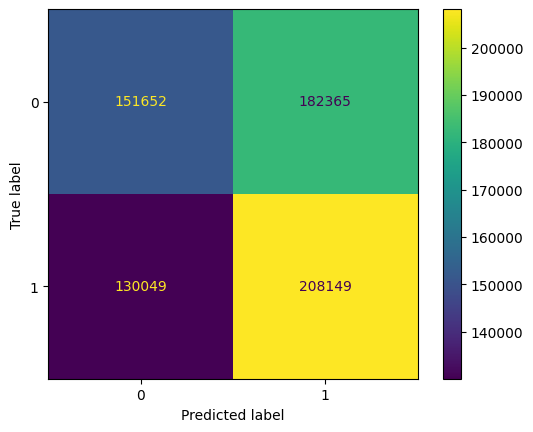

In [62]:
confusion = confusion_matrix(Y_target[:,0], Y_predict[:,0])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()

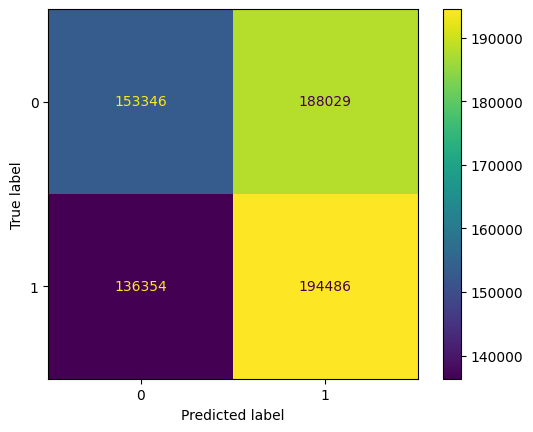

In [63]:
confusion = confusion_matrix(Y_target[:,3], Y_predict[:,3])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()

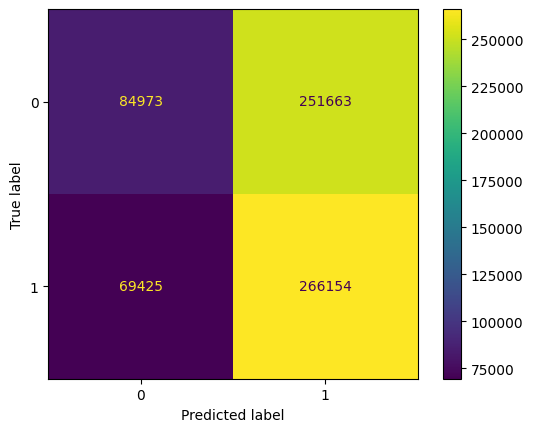

In [64]:
confusion = confusion_matrix(Y_target[:,6], Y_predict[:,6])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()

In [65]:
# use the average prediction to predict 960 second return direction

In [66]:
Y_median = np.median(Y_predict, axis=1)

In [67]:
(Y_target[:,6] == Y_median).sum() / Y_target.shape[0]

0.5211085738937691

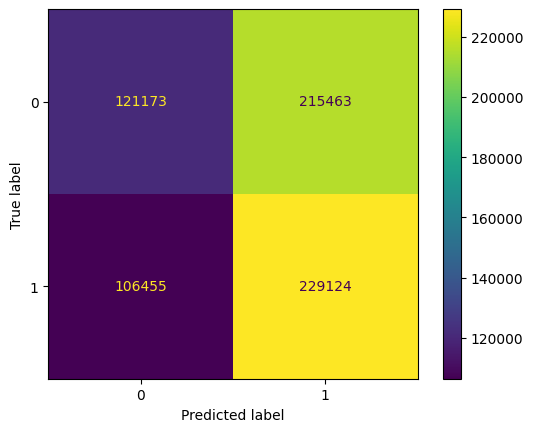

In [68]:
confusion = confusion_matrix(Y_target[:,6], Y_median)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()

In [69]:
Y_avg = (np.mean(Y_output, axis=1) > 0.5).astype(np.float32)

In [70]:
(Y_target[:,6] == Y_avg).sum() / Y_target.shape[0]

0.5225277626949711

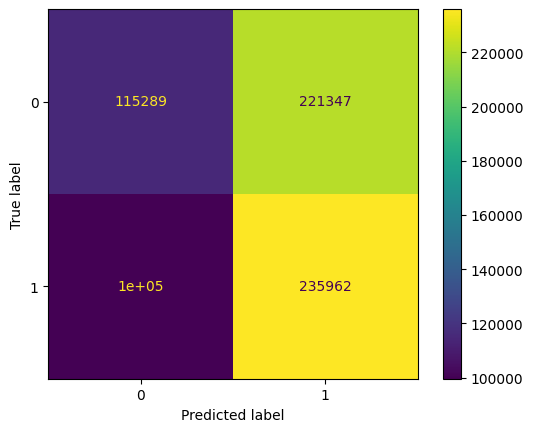

In [71]:
confusion = confusion_matrix(Y_target[:,6], Y_avg)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()

In [84]:
f1_score(Y_target[:,6], Y_predict[:,6])

0.6237526306661856

In [85]:
recall_score(Y_target[:,6], Y_predict[:,6])

0.7931187589211482

In [91]:
accuracy_score(Y_target[:,6], Y_predict[:,6])

0.5223432979032007

In [87]:
f1_score(Y_target[:,6], Y_avg)

0.595196295063111

In [88]:
recall_score(Y_target[:,6], Y_avg)

0.703148885955319

In [93]:
accuracy_score(Y_target[:,6], Y_avg)

0.5225277626949711

In [72]:
scores, Y_predict, tvs = score(model, device, score_loader)

In [73]:
scores

array([  4.17159762,   3.35895225,  -2.65492209,  -9.02084053,
       -20.19112867, -23.71674601,  -0.03261967])

In [74]:
scores

array([  4.17159762,   3.35895225,  -2.65492209,  -9.02084053,
       -20.19112867, -23.71674601,  -0.03261967])

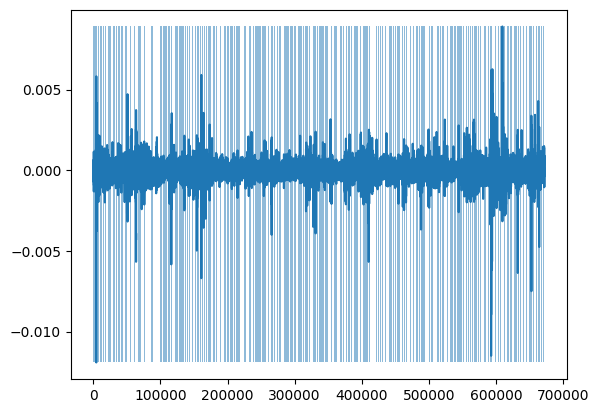

In [75]:
fig, ax = plt.subplots()
ax.plot(tvs[:,0])
ax.fill_between(range(tvs.shape[0]), min(tvs[:,0]), max(tvs[:,0]), where=Y_predict[:,0] == 1., alpha=0.5)

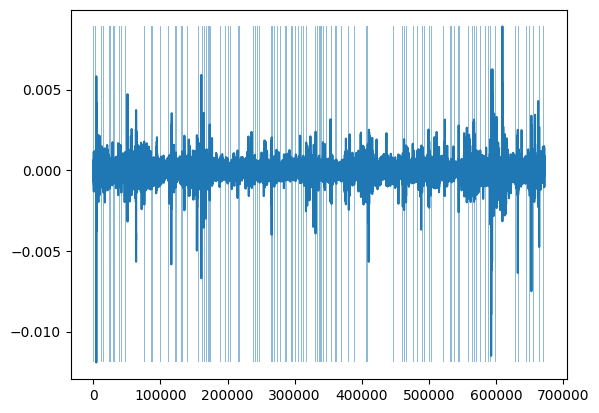

In [76]:
#plot of wrong decisions
fig, ax = plt.subplots()
ax.plot(tvs[:,0])
ax.fill_between(range(tvs.shape[0]), min(tvs[:,0]), max(tvs[:,0]), where=(Y_predict[:,0] * tvs[:,0]) < 0., alpha=0.5)

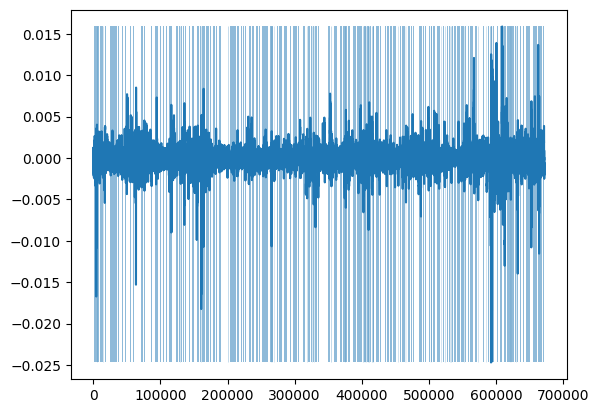

In [77]:
fig, ax = plt.subplots()
ax.plot(tvs[:,3])
ax.fill_between(range(tvs.shape[0]), min(tvs[:,3]), max(tvs[:,3]), where=Y_predict[:,3] == 1., alpha=0.5)

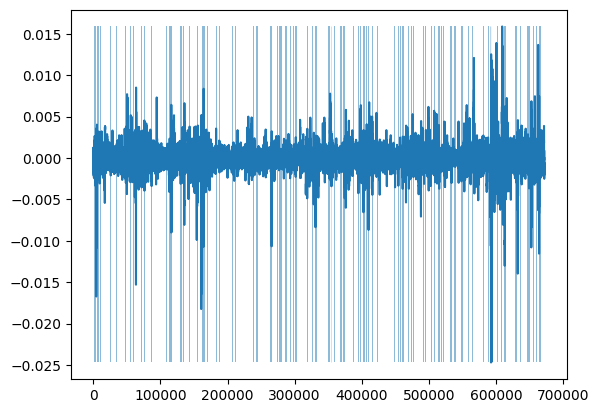

In [78]:
#plot of bad decisions
fig, ax = plt.subplots()
ax.plot(tvs[:,3])
ax.fill_between(range(tvs.shape[0]), min(tvs[:,3]), max(tvs[:,3]), where=(Y_predict[:,3] * tvs[:,3]) < 0., alpha=0.5)

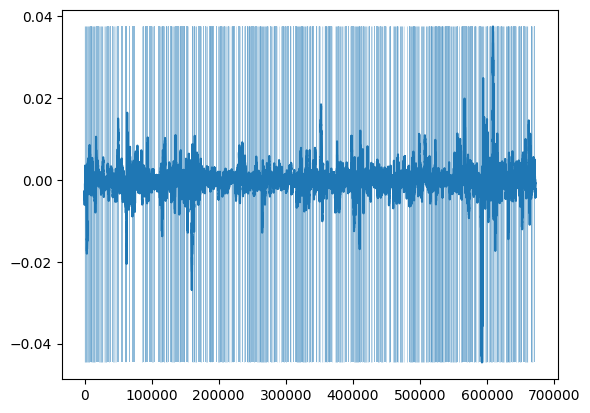

In [79]:
fig, ax = plt.subplots()
ax.plot(tvs[:,6])
ax.fill_between(range(tvs.shape[0]), min(tvs[:,6]), max(tvs[:,6]), where=Y_predict[:,6] == 1., alpha=0.5)

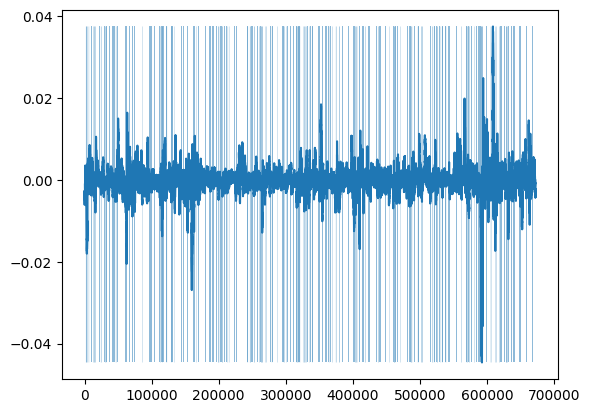

In [80]:
#plot of bad decisions
fig, ax = plt.subplots()
ax.plot(tvs[:,6])
ax.fill_between(range(tvs.shape[0]), min(tvs[:,6]), max(tvs[:,6]), where=(Y_predict[:,6] * tvs[:,6]) < 0., alpha=0.5)

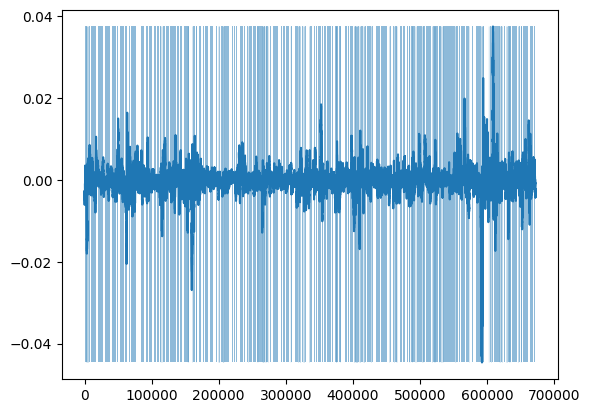

In [81]:
fig, ax = plt.subplots()
ax.plot(tvs[:,6])
ax.fill_between(range(tvs.shape[0]), min(tvs[:,6]), max(tvs[:,6]), where=Y_avg == 1., alpha=0.5)

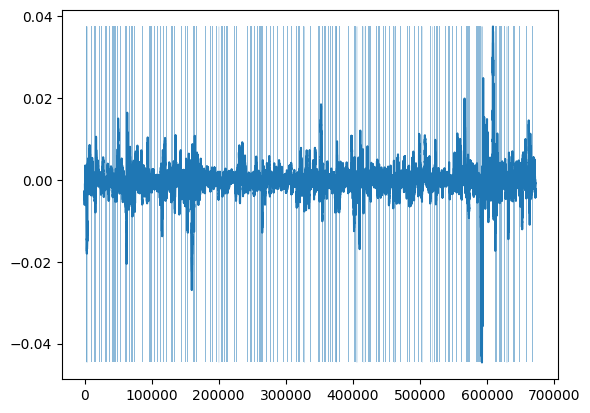

In [82]:
#plot of bad decisions
fig, ax = plt.subplots()
ax.plot(tvs[:,6])
ax.fill_between(range(tvs.shape[0]), min(tvs[:,6]), max(tvs[:,6]), where=(Y_avg * tvs[:,6].numpy()) < 0., alpha=0.5)